In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch 
import torch.nn as nn
import numpy as np
from typing import Tuple, Callable, List

from common.pinn_base import BasePINN, PINNConfig
from common.pt_pinn import PT_PINN, PreTrainingConfig
from common.trainer import PINNTrainer, TrainerConfig
from common.visualizer import PINNVisualizer

In [2]:
class ResNetBlock(nn.Module):
    """Implementation of a ResNet block with 3 layers"""
    def __init__(self, width: int):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(0.1))  # Inicialización pequeña
        self.block = nn.Sequential(
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # return x + self.block(x)
        return x + self.scale * self.block(x)  # Scaled residual

In [3]:
class HeatEquationResNet(BasePINN):
    def __init__(self, input_dim: int, output_dim: int, config: PINNConfig):
        super().__init__(input_dim, output_dim, config)
        
        width = config.neurons_per_layer
        
        # Improved initialization
        self.scaling = nn.Parameter(torch.tensor([1.0]))
        
        # Entrada con normalización
        layers = [
            nn.Linear(input_dim, width),
            nn.BatchNorm1d(width),
            nn.Tanh()
        ]
        
        # ResNet blocks con skip connections mejoradas
        for _ in range(5):
            layers.extend([
                ResNetBlock(width),
                nn.BatchNorm1d(width),
                nn.Tanh()
            ])
            
        # Capa de salida con scaling
        layers.append(nn.Linear(width, output_dim))
        
        self.network = nn.Sequential(*layers)

In [4]:
def get_exact_solution(x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Calculate exact solution u(x,y,t) = 2 + sin(30πt + πxy)"""
    return 2 + torch.sin(30 * np.pi * t + np.pi * x * y)

In [5]:
def get_source_term(x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Calculate source term Q(x,y,t) derived from the exact solution"""
    # u_t term
    u_t = 30 * np.pi * torch.cos(30 * np.pi * t + np.pi * x * y)
    
    # u_xx + u_yy terms
    u_xx = -(np.pi * y)**2 * torch.sin(30 * np.pi * t + np.pi * x * y)
    u_yy = -(np.pi * x)**2 * torch.sin(30 * np.pi * t + np.pi * x * y)
    
    return u_t - (u_xx + u_yy)

In [6]:
def create_pde_operator(model: nn.Module) -> Callable:
    def pde_operator(xy: torch.Tensor) -> torch.Tensor:
        xy.requires_grad_(True)
        u = model(xy)
        
        # Compute gradients with respect to inputs
        grad_u = torch.autograd.grad(u.sum(), xy, create_graph=True)[0]
        u_t = grad_u[:, 2:3]
        u_x = grad_u[:, 0:1]
        u_y = grad_u[:, 1:2]
        
        # Compute second derivatives
        grad_u_x = torch.autograd.grad(u_x.sum(), xy, create_graph=True)[0]
        grad_u_y = torch.autograd.grad(u_y.sum(), xy, create_graph=True)[0]
        u_xx = grad_u_x[:, 0:1]
        u_yy = grad_u_y[:, 1:2]
        
        # Compute source term
        Q = get_source_term(xy[:, 0:1], xy[:, 1:2], xy[:, 2:3])
        
        return u_t - (u_xx + u_yy) - Q
        
    return pde_operator

In [7]:
def generate_training_data(n_i: int, n_b: int, n_r: int) -> Tuple:
    """Generate training data points"""
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initial condition points (t=0)
    x_i = torch.rand(n_i, device=device)
    y_i = torch.rand(n_i, device=device)
    t_i = torch.zeros(n_i, device=device)
    xy_i = torch.stack([x_i, y_i, t_i], dim=1)
    u_i = get_exact_solution(x_i, y_i, t_i)
    
    # Boundary points
    t_b = torch.rand(n_b, device=device)
    
    # x=0 and x=1 boundaries
    x_b1 = torch.zeros(n_b//4, device=device)
    x_b2 = torch.ones(n_b//4, device=device)
    y_b12 = torch.rand(n_b//2, device=device)
    t_b12 = t_b[:n_b//2]
    
    # y=0 and y=1 boundaries
    y_b3 = torch.zeros(n_b//4, device=device)
    y_b4 = torch.ones(n_b//4, device=device)
    x_b34 = torch.rand(n_b//2, device=device)
    t_b34 = t_b[n_b//2:]
    
    # Combine boundary points
    x_b = torch.cat([x_b1, x_b2, x_b34])
    y_b = torch.cat([y_b12[:n_b//4], y_b12[n_b//4:], y_b3, y_b4])
    t_b = torch.cat([t_b12[:n_b//4], t_b12[n_b//4:], t_b34])
    xy_b = torch.stack([x_b, y_b, t_b], dim=1)
    u_b = get_exact_solution(x_b, y_b, t_b)
    
    # Residual points
    x_r = torch.rand(n_r, device=device)
    y_r = torch.rand(n_r, device=device)
    t_r = torch.rand(n_r, device=device)
    xy_r = torch.stack([x_r, y_r, t_r], dim=1)
    
    return xy_i, u_i, xy_b, u_b, xy_r

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

Training on cuda


In [9]:
# Model configurations
pinn_config = PINNConfig(
    hidden_layers=7,
    neurons_per_layer=120,  # Increased width
    activation=nn.Tanh(),
    w_initial=5.0,    # Aumentado para fortalecer condición inicial
    w_boundary=5.0,   # Aumentado para fortalecer condiciones de frontera
    w_residual=0.1    # Reducido para balancear con otras pérdidas
)

pt_config = PreTrainingConfig(
    intervals=[0.05, 0.2, 1.0],  # pre-training intervals
    n_supervised_points=500,  # More supervised points
    supervised_weight=2.0,  # Increased supervised weight
    adam_iterations=3000,
    resampling_ratio=0.6
)

trainer_config = TrainerConfig(
    adam_iterations=5000,
    initial_lr=5e-4,  # Reduced learning rate
    lr_decay_rate=0.95,  # Slower decay
    lr_decay_steps=200,
    resampling_enabled=True,
    resampling_ratio=0.4,
    resampling_interval=50,  # More frequent resampling
    resampling_termination=4500
)

In [10]:
# Generate training data
xy_i, u_i, xy_b, u_b, xy_r = generate_training_data(800, 1600, 8000)

# Create models
standard_model = HeatEquationResNet(3, 1, pinn_config).to(device)
pt_model = PT_PINN(3, 1, pinn_config, pt_config).to(device)

# Create PDE operators for each model
standard_pde_op = create_pde_operator(standard_model)
pt_pde_op = create_pde_operator(pt_model)

# Create trainers
standard_trainer = PINNTrainer(standard_model, trainer_config)
pt_trainer = PINNTrainer(pt_model, trainer_config)

In [11]:
# Train models
print("Training standard PINN...")
standard_history = standard_trainer.train(
    xy_i, u_i, xy_b, u_b, xy_r,
    torch.tensor([[0, 1], [0, 1], [0, 1]], device=device),
    standard_pde_op
)

print("\nTraining PT-PINN...")
pt_history = pt_trainer.train(
    xy_i, u_i, xy_b, u_b, xy_r,
    torch.tensor([[0, 1], [0, 1], [0, 1]], device=device),
    pt_pde_op
)

Training standard PINN...
Starting Adam optimization phase...
Step 0: Loss = 500.551392
Step 100: Loss = 476.251984
Step 200: Loss = 430.442261
Step 300: Loss = 416.021912
Step 400: Loss = 392.614471
Step 500: Loss = 383.449615
Step 600: Loss = 358.253296
Step 700: Loss = 392.795288
Step 800: Loss = 324.115753
Step 900: Loss = 315.824829
Step 1000: Loss = 305.187897
Step 1100: Loss = 298.441772
Step 1200: Loss = 321.698334
Step 1300: Loss = 274.850769
Step 1400: Loss = 274.623444
Step 1500: Loss = 274.816742
Step 1600: Loss = 336.448761
Step 1700: Loss = 272.731781
Step 1800: Loss = 231.939316
Step 1900: Loss = 226.132355
Step 2000: Loss = 296.489563
Step 2100: Loss = 207.030289
Step 2200: Loss = 293.585602
Step 2300: Loss = 232.197754
Step 2400: Loss = 233.170044
Step 2500: Loss = 195.368652
Step 2600: Loss = 239.887253
Step 2700: Loss = 188.460648
Step 2800: Loss = 191.529465
Step 2900: Loss = 272.273224
Step 3000: Loss = 171.836578
Step 3100: Loss = 170.111450
Step 3200: Loss = 189.

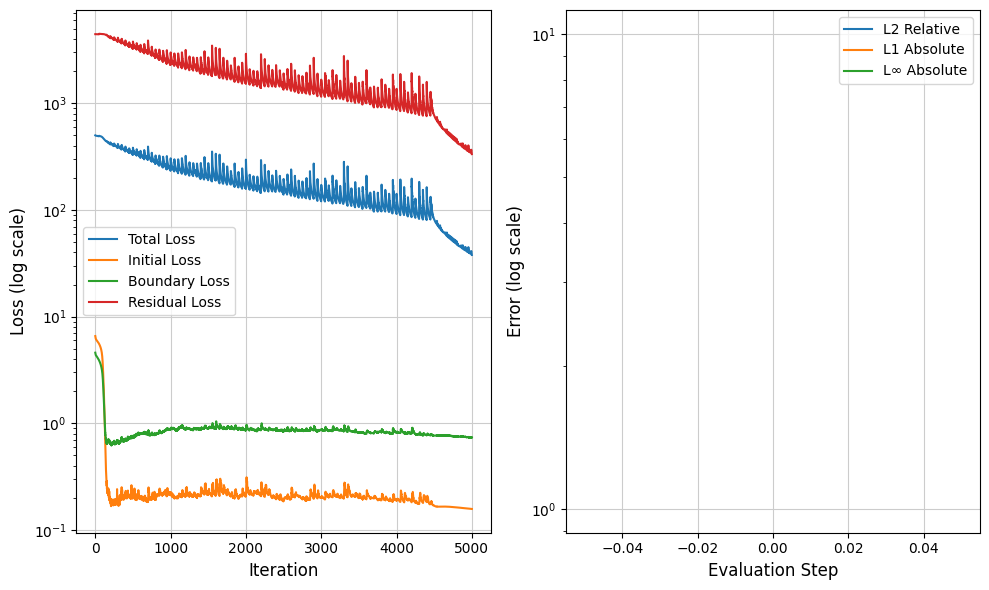

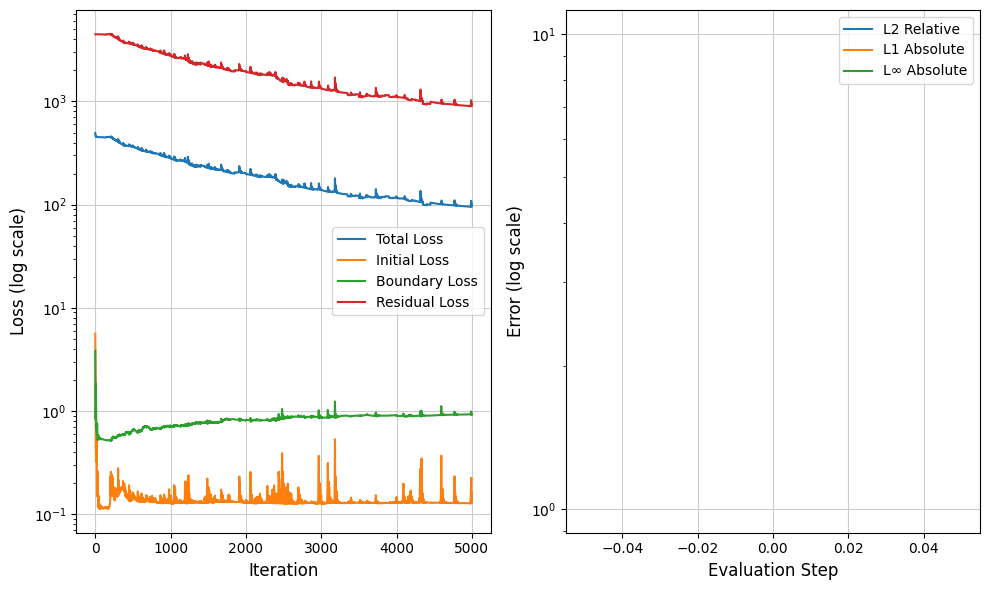

In [12]:
# Visualization
visualizer = PINNVisualizer()

# Plot training histories
visualizer.plot_training_history(standard_history, "standard_history.png")
visualizer.plot_training_history(pt_history, "pt_history.png")

In [13]:
# Generate test data for visualization
x = torch.linspace(0, 1, 100, device=device)
y = torch.linspace(0, 1, 100, device=device)
t = torch.tensor([1.0], device=device)

X, Y = torch.meshgrid(x, y)
xy_test = torch.stack([X.flatten(), Y.flatten(), 
                        t.repeat(10000)], dim=1)

c:\Users\mated\anaconda3\envs\torch_win39\lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
# Get predictions
with torch.no_grad():
    standard_pred = standard_model(xy_test).reshape(100, 100)
    pt_pred = pt_model(xy_test).reshape(100, 100)
    exact = get_exact_solution(X, Y, t).reshape(100, 100)

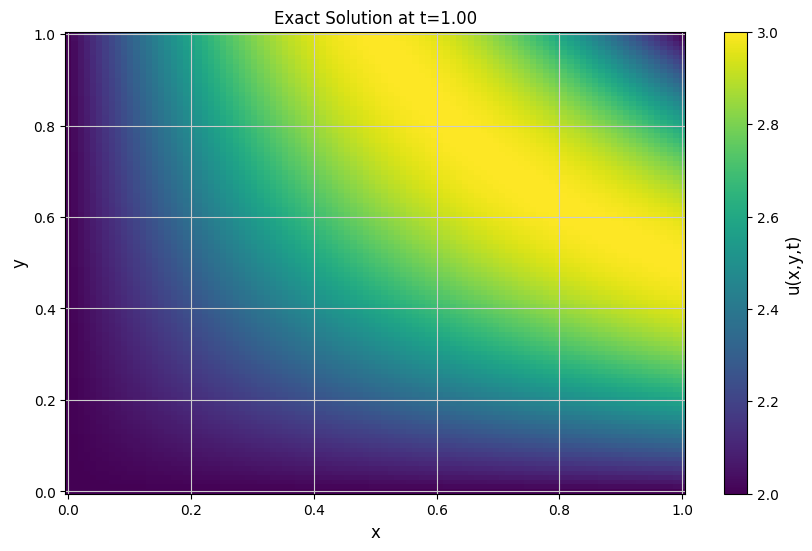

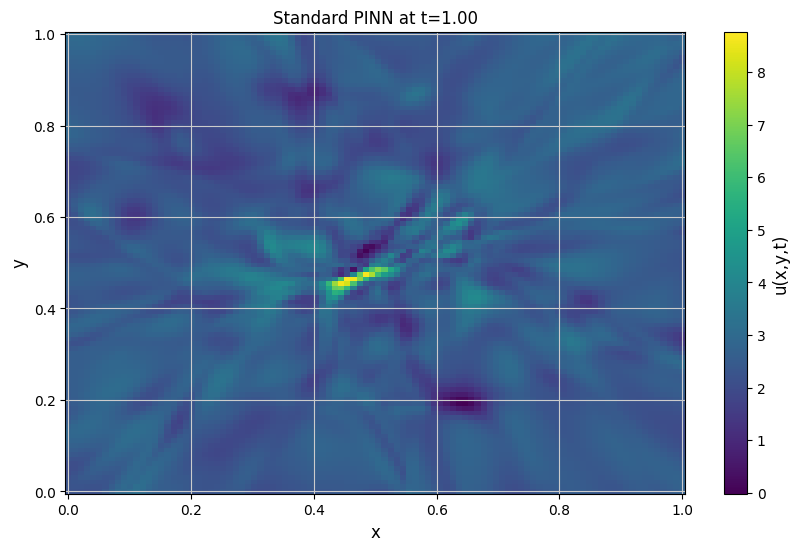

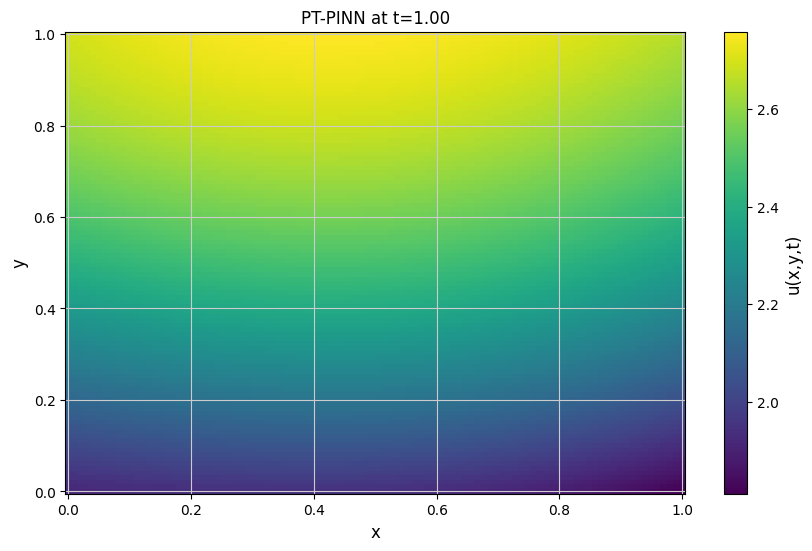

In [15]:
# Plot solutions at t=1.0
visualizer.plot_2d_solution(X, Y, exact, 1.0, "Exact Solution")
visualizer.plot_2d_solution(X, Y, standard_pred, 1.0, "Standard PINN")
visualizer.plot_2d_solution(X, Y, pt_pred, 1.0, "PT-PINN")

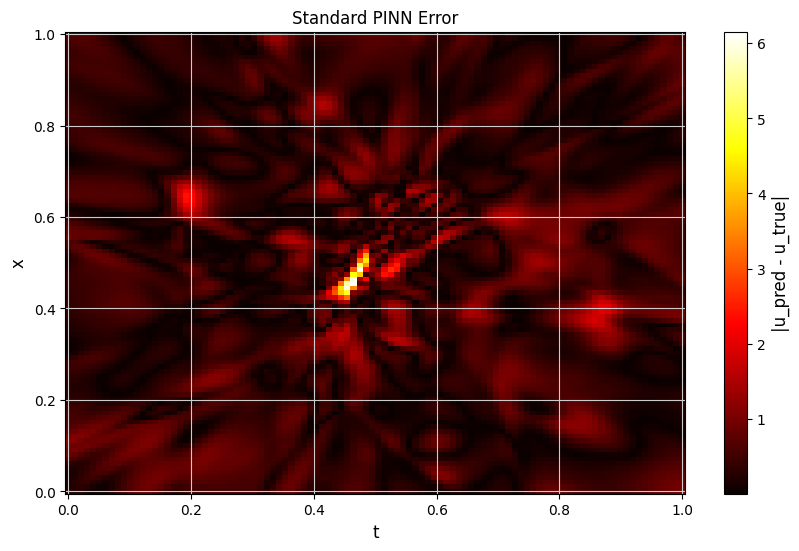

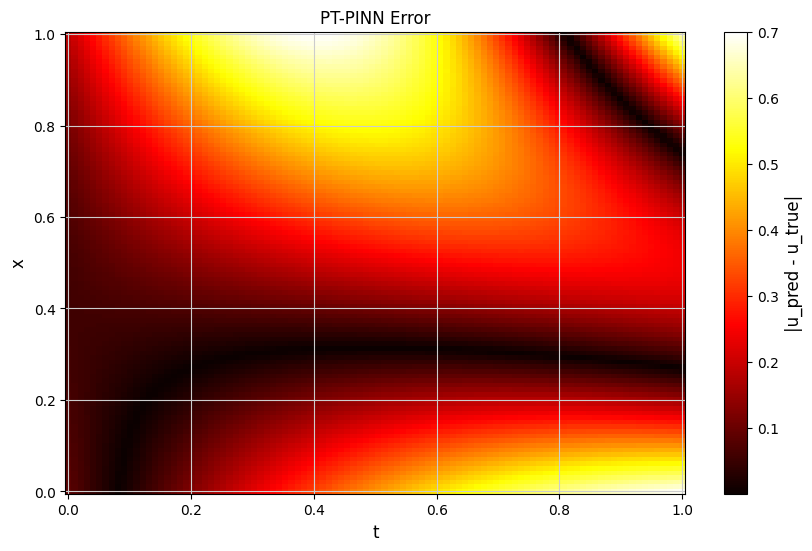

In [16]:
# Plot error heatmaps
visualizer.plot_error_heatmap(
    torch.abs(standard_pred - exact), x, y,
    "Standard PINN Error"
)
visualizer.plot_error_heatmap(
    torch.abs(pt_pred - exact), x, y,
    "PT-PINN Error"
)